In [23]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import geopandas as gpd
import matplotlib.pyplot as plt
from sodapy import Socrata
import cenpy
from scipy.stats import pearsonr
from shapely import wkt

In [3]:
client = Socrata("data.cityofnewyork.us", os.environ['nyc_soda_cuny_token'])

In [ ]:
# Downloading property valuation through the Socrata API can take hours
# valuation = client.get("yjxr-fw8i", limit=10000000)

In [ ]:
# Downloading building footprints through the Socrata API can take hours
# bldgs = client.get("s75a-ei9u", limit=2000000)

# TO DO:
- download property valuation
- download building footprints
- merge the above two
- create distance metrics
- run analysis
- visualize

In [28]:
valuation = pd.read_csv('data/Property_Valuation_and_Assessment_Data.csv',
                        dtype={'BORO': str, 'BLOCK': str, 'LOT': str})

In [32]:
valuation = valuation[valuation['YEAR'] == '2018/19']
valuation['bbl'] = valuation['BORO'] + valuation['BLOCK'] + valuation['LOT']

In [34]:
valuation = valuation.dropna(subset=['Latitude'])
print(valuation.shape)
valuation.head(2)

(1080953, 41)


,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,...,Borough,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,NTA,New Georeferenced Column,bbl
2615,1002007501,1,200,7501,NaN,OWNER / AGENT,R0,2,0,0,...,MANHATTAN,40.716989,-73.998297,103.0,1.0,29.0,1080816.0,Chinatown,POINT (-73.998297 40.716989),12007501
7560,1003967501,1,396,7501,NaN,NaN,R0,2,49,88,...,MANHATTAN,40.728875,-73.978428,103.0,2.0,28.0,1088495.0,Lower East Side,POINT (-73.978428 40.728875),13967501


In [35]:
valuation.rename(columns={'New Georeferenced Column': 'geom'}, inplace=True)
valuation['geom'] = valuation['geom'].apply(wkt.loads)

In [36]:
bldgs = pd.read_csv('data/building.csv', 
                    dtype={'BASE_BBL': str, 'MPLUTO_BBL': str})
bldgs['the_geom'] = bldgs['the_geom'].apply(wkt.loads)
print(bldgs.shape)
bldgs.head(2)

(1084926, 15)


,BIN,the_geom,NAME,LSTMODDATE,CNSTRCT_YR,LSTSTATYPE,DOITT_ID,HEIGHTROOF,FEAT_CODE,GROUNDELEV,SHAPE_AREA,SHAPE_LEN,BASE_BBL,MPLUTO_BBL,GEOMSOURCE
0,3394646,(POLYGON ((-73.87129515296562 40.6571737004345...,NaN,08/22/2017 12:00:00 AM +0000,2009.0,Constructed,1212853,21.608508,2100.0,18.0,854.662433,125.079796,3044520815,3044520815,Photogramm
1,4548330,(POLYGON ((-73.87670970144625 40.7142523454162...,NaN,08/17/2017 12:00:00 AM +0000,1930.0,Constructed,1226227,10.360000,5110.0,122.0,217.594243,60.225858,4030640041,4030640041,Photogramm


In [37]:
bldgs = gpd.GeoDataFrame(bldgs, geometry='the_geom')
valuation = gpd.GeoDataFrame(valuation, geometry='geom')

In [56]:
combined = bldgs.merge(valuation, left_on='MPLUTO_BBL',
                       right_on='BBLE')

In [84]:
classes = ['1', '2', '2A', '2B', '1D', '2C', '1B']
combined = combined[combined['TAXCLASS'].isin(classes)]

In [85]:
print(combined.shape)
combined.head(2)

(999945, 56)


,BIN_x,the_geom,NAME,LSTMODDATE,CNSTRCT_YR,LSTSTATYPE,DOITT_ID,HEIGHTROOF,FEAT_CODE,GROUNDELEV,...,Borough,Latitude,Longitude,Community Board,Council District,Census Tract,BIN_y,NTA,geom,bbl
0,3394646,"MULTIPOLYGON (((-73.87130 40.65717, -73.87136 ...",NaN,08/22/2017 12:00:00 AM +0000,2009.0,Constructed,1212853,21.608508,2100.0,18.0,...,BROOKLYN,40.657362,-73.871400,305.0,42.0,1070.0,3394646.0,East New York,POINT (-73.87140 40.65736),34452815
1,4548330,"MULTIPOLYGON (((-73.87671 40.71425, -73.87677 ...",NaN,08/17/2017 12:00:00 AM +0000,1930.0,Constructed,1226227,10.360000,5110.0,122.0,...,QUEENS,40.714445,-73.877152,405.0,30.0,65703.0,4071750.0,Middle Village,POINT (-73.87715 40.71444),4306441


In [86]:
combined['AVLAND'].max()

134506350

In [87]:
combined['AVLAND'].median()

9469.0

In [88]:
combined['AVLAND'].min()

0

<AxesSubplot:>

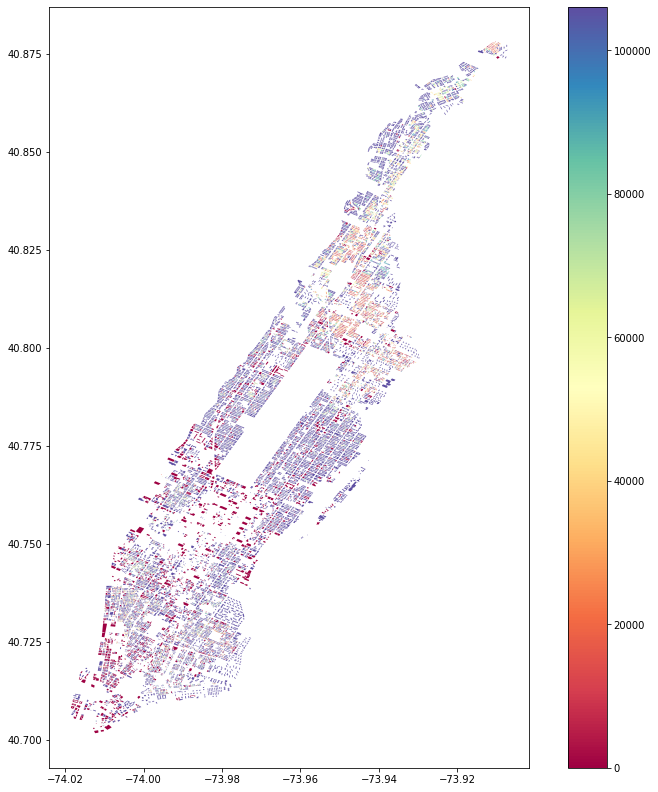

In [89]:
combined[combined['BORO'] == '1'].plot(column='AVLAND', 
              vmin=0, vmax=106050, cmap='Spectral',
              legend=True, figsize=(14, 14))

In [9]:
poi = client.get("8mtx-gvr5", limit=25500)
poi_df = pd.DataFrame.from_records(poi)

In [10]:
poi_df['the_geom'] = poi_df['the_geom'].apply(lambda x: shape(x))

In [11]:
poi_df.shape

(20656, 16)

In [12]:
poi_df

,the_geom,segmentid,saftype,complexid,sos,placeid,faci_dom,bin,borough,created,modified,facility_t,source,b7_sc,pri_add,name
0,POINT (-73.93149397004032 40.84419199998088),193927,N,401,1,1031153,8,0,1,2018-04-12T00:00:00.000Z,2020-03-12T00:00:00.000Z,6,DCP,11095502,0,HRD RAMP TO GWB OVER HRD SB
1,POINT (-74.19672999194501 40.63526107028508),321726,N,0,1,19954,8,0,5,2008-03-15T00:00:00.000Z,2020-03-16T00:00:00.000Z,6,DCP,59703501,0,GOETHALS
2,POINT (-73.95802161052769 40.75848681229432),138896,N,0,1,1026908,8,0,1,2015-10-20T00:00:00.000Z,2020-03-16T00:00:00.000Z,6,DoITT,19792015,0,KOCH BR PEDESTRIAN AND BIKE PATH
3,POINT (-73.95061614358269 40.75529956768712),139388,N,0,1,1026909,8,0,4,2015-10-20T00:00:00.000Z,2020-03-16T00:00:00.000Z,6,DoITT,49734017,0,KOCH BR PEDESTRIAN AND BIKE
4,POINT (-73.81678346994171 40.78815244048363),179357,N,0,2,1031297,8,0,4,2018-04-13T00:00:00.000Z,2018-04-19T00:00:00.000Z,6,DCP,40074101,0,14 AV OV BELT CROSS ISL PKWY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20651,POINT (-73.95159296591457 40.81139323185263),38638,N,0,2,15663,12,0,1,2009-05-14T00:00:00.000Z,2020-10-02T00:00:00.000Z,4,DoITT,10134701,0,WILLIAM B WASHINGTON MEMORIAL GARDEN
20652,POINT (-73.95140390048451 40.79328938588645),37833,N,0,2,1020004,1,1051499,1,2013-05-02T00:00:00.000Z,2020-10-02T00:00:00.000Z,13,OTHER,10131701,1040276,ARSENAL NORTH BUILDING
20653,POINT (-73.98292518976267 40.76994205396062),164813,N,0,1,1035400,1,1027194,1,2020-06-24T00:00:00.000Z,2020-10-02T00:00:00.000Z,8,OTHER,10121501,10179600,ARSENAL WEST
20654,POINT (-73.8886496267617 40.80588947806008),77564,X,4998,2,1035469,10,2117747,2,2020-07-02T00:00:00.000Z,2020-10-02T00:00:00.000Z,4,OTHER,21338503,5197857,BARRETTO POINT PARK COMFORT STATION
